In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from math import floor
from scipy.sparse import hstack
from scipy.sparse import load_npz
from sklearn.pipeline import Pipeline

# Diabetes study

**Index**

1. [Problem understanding](#Problem-understanding)
2. [Data understanding](#Data-understanding)
3. [Data preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)

<a id="problem-understanding"></a>
## 1. Problem understanding

Hospital readmission (particularly within 30 days of discharge) is seen as a a high-priority health care quality measure and target for cost reduction. (Rubin, 2015) One in five Medicare beneficiaries is **readmitted within 30 days**, at a cost of over $26 billion per year, and, in this regard, diabetes is a major contributor to risk for hospital readmission, representing nearly one-fifth of all unplanned readmissions. (Soh et al., 2020) 

To encourage improvement in the quality of care and a reduction in unnecessary health expense, policymakers, reimbursement strategists, and the United States government have made reducing 30-day hospital readmissions a national priority. Achieving this goal, however, requires more complete understanding of the underlying causes of readmission. (Lepin et al., 2014)

Why would a patient be early readmitted in the first? Here are a few hypotheses:

- Patient isn't properly diagnosed as diabetic in the first admission;
- Hospital doesn't give proper care, namely
    - insufficient exams;
    - insufficient medical intervention (medication change or procedures);
- Poor patient health.
 
Patient characteristics such as gender, age, race, and comorbidities, may affect the outcomes (Soh et al. 2020), so they could be used to model patient early readmission.

<u>**Objective**</u>

In this work I will try to answer the following questions:

- Are readmitted diabetic patients correctly diagnosed in their first admission?
- Given that HbA1c values are key for planning the diabetic patient's medication (according to the literature), how often HbA1c exams are asked by physicians in the inpatient setting?
- Are readmitted diabetic patients receiving appropriate medical intervention, like change in their medication or medical procedures if need be?
- Which variables are the strongest readmission predictors?
- And finally, would it be possible to create a predictive model for early readmission? Such a model could help plan interventions for high-risk patients and reduce costs for both patients and hospitals. 

The target variable in this case is going to be unplanned readmissions that happen within 30 days of discharge from the initial admission, since they represent most of the patient readmissions (source needed).

<a id="data-understanding"></a>
## Data understanding

The data set comprises two files, `diabetic_data.csv` and `IDs_mapping.csv`. The former contains anonymized medical data collected during 100k encounters accross several hospitals in the United States over a decade. The latter contains a legend for some of the numerical categories (like admission type and discharge disposition).

Each file has been extracted and zipped individually to optimize storage in the disk.

In [61]:
df = pd.read_csv("../data/diabetic_data.zip")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


With a bit of research, I've found out an article by Strack et al. (2014), who are the people behind making this data set pubicly available. In their article, the authors make a rundown of each category and what they mean:

- **Encounter ID** - Unique identifier of an encounter
- **Patient number** - Unique identifier of a patient
- **Race Values** - Values: Caucasian, Asian, African American, Hispanic, and other
- **Gender Values** - Values: male, female, and unknown/invalid
- **Age Grouped in 10-year intervals** - 0, 10), 10, 20), …, 90, 100)
- **Weight** - Weight in pounds
- **Admission type** - Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- **Discharge disposition** - Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- **Admission source** - Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- **Time in hospital** - Integer number of days between admission and discharge
- **Payer code** - Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
- **Medical specialty** - Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- **Number of lab procedures** - Number of lab tests performed during the encounter
- **Number of procedures** - Numeric Number of procedures (other than lab tests) performed during the encounter
- **Number of medications** - Number of distinct generic names administered during the encounter
- **Number of outpatient visits** - Number of outpatient visits of the patient in the year preceding the encounter
- **Number of emergency visits** - Number of emergency visits of the patient in the year preceding the encounter
- **Number of inpatient visits** - Number of inpatient visits of the patient in the year preceding the encounter
- **Diagnosis 1** - The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- **Diagnosis 2** - Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- **Diagnosis 3** - Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- **Number of diagnoses** - Number of diagnoses entered to the system 0%
- **Glucose serum test result** - Indicates the range of the result or if the test was not taken. Values - “>200,” “>300,” “normal,” and “none” if not measured
- **A1c test result** - Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- **Change of medications** - Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
- **Diabetes medications** - Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
- **24 features for medications** - columns named after diabetes-related medication indicating whether the drug was prescribed or there was a change in dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
- **Readmitted** - Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

Missing values are represented by question marks in this data set. They must be replaced with np.nan if we want to use Pandas' default methods to view and handle missing data.

In [62]:
df.replace("?", np.nan, inplace=True)

Overral view of the dataframe, including missing values and dtypes:

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

I need more details about possible values. Knowing the variable's dtypes only won't be enough, so let's see some examples of what to expect.

In [64]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in df:
    uniques = set(df[column])
    n_uniques = len(uniques)
    missing = df[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)

Variable              Unique     % Missing  Examples
encounter_id              101766     0.0    [77856768, 173015040, 84934662, 273678342, 17563668]
patient_nbr               71518      0.0    [33947649, 92667906, 82706436, 83623941, 128319494]
race                      6          2.2    [nan, 'Asian', 'AfricanAmerican', 'Other', 'Caucasian']
gender                    3          0.0    ['Female', 'Unknown/Invalid', 'Male']
age                       10         0.0    ['[30-40)', '[50-60)', '[40-50)', '[20-30)', '[60-70)']
weight                    10         96.9   [nan, '[25-50)', '[175-200)', '[125-150)', '[0-25)']
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                18         39.6   [nan, 'MC', 'BC', 'MP', 'CM']
medical_specialty         73         49.1

The data set is moderately unbalanced, with the positive class (`readmitted = "<30"`) comprising  11% of the data set.

In [65]:
df.readmitted.value_counts(normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

Evaluating the number of patients to whom diabetes medication was prescribred during the inpatient settings:

In [66]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
#drugs_values = ["No", "Up", "Steady", "Down"]
df[drugs].apply(pd.value_counts).T

,Down,No,Steady,Up
metformin,575.0,81778.0,18346.0,1067.0
repaglinide,45.0,100227.0,1384.0,110.0
nateglinide,11.0,101063.0,668.0,24.0
chlorpropamide,1.0,101680.0,79.0,6.0
glimepiride,194.0,96575.0,4670.0,327.0
acetohexamide,NaN,101765.0,1.0,NaN
glipizide,560.0,89080.0,11356.0,770.0
glyburide,564.0,91116.0,9274.0,812.0
tolbutamide,NaN,101743.0,23.0,NaN
pioglitazone,118.0,94438.0,6976.0,234.0


###  The most common diagnosis among readmitted and non-readmitted patients

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:title={'center':'Outcome = readmission'}>

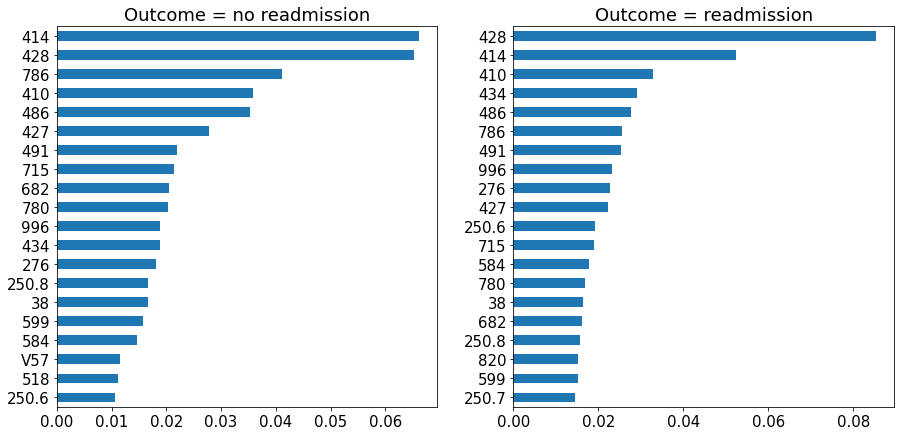

In [67]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

df[df["readmitted"] != "<30"]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(20) \
    .plot(kind="barh", title="Outcome = no readmission")

plt.subplot(1,2,2)
df[df["readmitted"] == "<30"]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(20) \
    .plot(kind="barh", title="Outcome = readmission")

10 Most common _primary_ diagnosis among the **non-readmitted**
- 414 Other forms of chronic ischemic heart disease
- 428 Heart failure
- 786 Symptoms involving respiratory system and other chest symptoms
- 410 Acute myocardial infarction
- 486 Pneumonia, organism unspecified
- 427 Cardiac dysrhythmias
- 491 Chronic bronchitis
- 715 Osteoarthrosis and allied disorders
- 682 Other cellulitis and abscess
- 780 General symptoms

10 Most common _primary_ diagnosis among the **early readmitted**
- 428 Heart failure
- 414 Other forms of chronic ischemic heart disease
- 410 Acute myocardial infarction
- 434 Occlusion of cerebral arteries
- 486 Pneumonia, organism unspecified
- 786 Symptoms involving respiratory system and other chest symptoms
- 491 Chronic bronchitis
- 996 Complications peculiar to certain specified procedures
- 276 Disorders of fluid, electrolyte, and acid-base balance
- 427 Cardiac dysrhythmias

Interesting insights:
- Occlusion of cerebral arteries (434) are slightly more common among readmitted patients (2% vs 3%).

### IDs Mapping

Now taking a look at `IDs_mapping.csv`, the file isn't in standard CSV format. It's actually a text file mapping numerical categories to strings. Using this file, I'll replace each number with the appropriate name in the original dataframe.

In [68]:
# Map for admission_type_id
admtype_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=0, nrows=8)

# Map for discharge_disposition_id
discharge_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=10, nrows=30)

# Map for admission_source_id
admsrc_map = pd.read_csv("../data/IDs_mapping.zip", skiprows=42, nrows=25)

In [69]:
admsrc_map.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


### More data set characteristics

- Covers a 10-year span (1999-2008).
- Hospital admissions in the data set are supposed to be diabetic-related **only**.
- Lab tests were performed during admission.
- Medications were administered during admission.
- Data set contains <u>multiple readmissions of the same people</u>.
- Lots of low-variance variables in this data set (e.g. `examide` and `citoglipton` have only 1 unique value), which won't add to the model's predictive power.
- `diag_1` to `diag_3` columns have too many ICD-9-CM codes and will have to be shortened
- Missing values:
  - `weight` variable is nearly useless, with about 97% of missing values.
  - `payercode` could be an useful variable, but has a concerning number of missing values (around 40%)
  - `medical_specialty` has half of its values missing.

**Target variable:** 30-day remission, i.e. unplanned or unexpected readmission to the same hospital within 30 days of being discharged.

<a id="data-preparation"></a>
## Data preparation


### Remove duplicates

There are a few rows in the data set that refer to the same patient number. Most machine learning models require the observations to be independent from each other. More specifically, the assumption is that observations shouldn't come from repeated measurements, so these will be deleted.

In [74]:
idx_dup = df.loc[df.duplicated(subset="patient_nbr", keep="first")].index

In [11]:
print("df size before:", df.shape[0])
df2 = df.drop_duplicates(subset="patient_nbr", keep="first")
print("df size after:", df2.shape[0])

df size before: 101766
df size after: 71518


### Drop unneeded features

- `encounter_id`, `patient_nbr`, and `payer_code`: irrelevant to patient outcome
- `weight`, `medical_specialty`: too many missing values.
- `num_lab_procedures`, `num_procedures`, and `num_medications`: highly correlated with days in hospital
- `admission_source_id`: redundant variable (`admission_type_id` already contains information about admission)
- all medications (except for metformin, glimepiride, glipizide, glyburide, pioglitazone, rosiglitazone, and insulin) too few people using them
- `diag_2` and `diag_ 3`: in the inpatient setting, the primary diagnosis is the most serious and/or resource-intensive during the hospitalization or the inpatient encounter. https://www.hcpro.com/HIM-324035-5707/QA-Primary-principal-and-secondary-diagnoses.html

In [12]:
df3 = df2.drop(["encounter_id",
                "patient_nbr",
                "payer_code",
                "weight",
                #'num_lab_procedures',  # high correlation with days in hospital
                #'num_procedures',  # high correlation with days in hospital
                #'num_medications',  # high correlation with days in hospital
                "medical_specialty",
                "admission_source_id",
                "repaglinide",
                "nateglinide",
                "chlorpropamide",
                "acetohexamide",
                "tolbutamide",
                "acarbose",
                "miglitol",
                "troglitazone",
                "tolazamide",
                "examide",
                "citoglipton",
                "glyburide-metformin",
                "glipizide-metformin",
                "glimepiride-pioglitazone",
                "metformin-rosiglitazone",
                "metformin-pioglitazone", 
                ], axis=1)

After dropping the unnecessary features, this is our new set of columns:

In [13]:
df3.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

#### Age

The age group feature in this data set can be turned into an ordinal variable, thus avoid creating too many new features after the one-hot encoding process.

In [14]:
age_map = {'[0-10)': 0,
           '[10-20)': 1,
           '[20-30)': 2,
           '[30-40)': 3,
           '[40-50)': 4,
           '[50-60)': 5,
           '[60-70)': 6,
           '[70-80)': 7,
           '[80-90)': 8,
           '[90-100)': 9}

df3["age"].replace(age_map, inplace=True)

#### Gender

Gender will be converted to either 0 if male and 1 if female.

In [15]:
df3["gender"] = df3["gender"].apply(lambda x: 1 if x == "Female" else 0)

#### Admission type ID

There are 9 distinct values in this column:

In [16]:
admtype_map

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


I'll split up this feature between "Emergency" (which will include "Urgent") and "other".

In [17]:
df3["emergency"] = df3["admission_type_id"].apply(lambda x: 1 if x in [1, 2] else 0)
df3.drop("admission_type_id", axis=1, inplace=True)

#### Discharge disposition ID

This feature has 29 distinct features, which would negatively impact the model's performance if we create dummy values from them. Therefore, I'm going to restrict these values to either "discharged to home" or other.

In [18]:
discharge_map.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...


In [19]:
df3["discharge_to_home"] = df3["discharge_disposition_id"].apply(lambda x: 1 if x in [1, 6, 8] else 0)
df3.drop("discharge_disposition_id", axis=1, inplace=True)

#### Diagnosis

The diagnosis features are represented by ICD-9 codes. The idea here is to condensate the hundreds of codes into just a few major groups. 

There are hundreds of different diseases being entered as the `diag`s features, so to avoid ending up with too many features after one-hot encoding them, I'll group them into a few major categories according to the list of ICD-9 codes on Wikipedia: 

    List of ICD-9 codes 001–139: infectious and parasitic diseases
    List of ICD-9 codes 140–239: neoplasms
    List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    List of ICD-9 codes 250.xx : diabetes mielitus
    List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    List of ICD-9 codes 290–319: mental disorders
    List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    List of ICD-9 codes 390–459: diseases of the circulatory system
    List of ICD-9 codes 460–519: diseases of the respiratory system
    List of ICD-9 codes 520–579: diseases of the digestive system
    List of ICD-9 codes 580–629: diseases of the genitourinary system
    List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    List of ICD-9 codes 740–759: congenital anomalies
    List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    List of ICD-9 codes 800–999: injury and poisoning
    List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [20]:
interval = lambda x,y: list(range(x,y+1))
diag = {
    "Circulatory": interval(390, 459) + [785],
    "Respiratory": interval(460,519) + [786],
    "Digestive": interval(520,579) + [786],
    "Diabetes": [250],
    "Injury": interval(800,999),
    "Musculoskeletal": interval(710,739),
    "Genitourinary": interval(580,629) + [788],
    "Neoplasms": interval(140,239),
    "Endocrine": interval(240,249)+interval(251,279),
    "General symptoms": [780,781,784] + interval(790,799),
    "Skin": interval(680,709) + [782],
    "Infection": interval(1,139),
    "Mental": interval(290,319),
    "External causes": [1000],
    "Blood": interval(280,289),
    "Nervous": interval(320,359),
    "Pregnancy": interval(630,679),
    "Sense organs": interval(360,389),
    "Congenital": interval(740, 759),
    "Unknown": [-1]
}
    
def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis
    
    return : str
    A major diagnostic category.
    """
    if (code[0] != "V") and (code[0] != "E"):
        code = floor(float(code))
    else:
        code = 1000
    for key in diag:
        if code in diag[key]:
            return key
    
#     try:
#         code = int(code)
#     except ValueError:
#         return "Other"
#     if (code >= 1) and (code < 140):
#         return "Infections"
#     elif (code >= 140) and (code < 250):
#         return "Endocrine"
#     elif (code >= 250) and (code < 251):
#         return "Diabetes"
#     elif (code >= 251) and (code <280):
#         return "Endocrine"
#     elif (code >= 280) and (code < 290):
#         return "Blood"
#     elif (code >= 290) and (code < 320):
#         return "Mental"
#     elif (code >= 320) and (code < 390):
#         return "Nervous system"
#     elif (code >= 390) and (code < 460) and (code != 434) and (code != 453):
#         return "Circulatory"
#     elif (code == 434):
#         return "Occlusion of cerebral arteries"
#     elif (code == 453):
#         return "Embolism and Thrombosis"
#     elif (code >= 460) and (code < 520):
#         return "Respiratory"
#     elif (code >= 520) and (code < 580):
#         return "Digestive"
#     elif (code >= 580) and (code < 630):
#         return "Genitourinary" 
#     elif (code >= 630) and (code < 680):
#         return "Pregnancy complications"
#     elif (code >= 680) and (code < 710):
#         return "Skin"
#     elif (code >= 710) and (code < 740):
#         return "Musculoskeletal"
#     elif code == 785:
#         return "Circulatory"
#     elif code == 786:
#         return "Respiratory"
#     elif code == 787:
#         return "Digestive"    
#     else: 
#         return "Other"
    
    

In [21]:
df3["diag_1"] = df3["diag_1"].fillna("-1").apply(icd)
df3["diag_2"] = df3["diag_2"].fillna("-1").apply(icd)
df3["diag_3"] = df3["diag_3"].fillna("-1").apply(icd)


### Glucose serum test result (max_glu_serum) and A1c test

This variable indicates the range of the result if the test was not taken. It can be converted into an ordinal variable and spare the creation of unnecessary one-hot features. According to the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451), a blood sugar level less than 140 mg/dL is normal. A reading between 140 and 199 mg/dL indicates prediabetes. A reading of more than 200 mg/dL after two hours indicates diabetes.

However, the data set isn't clear whether the glucose serum test was made during fasting or at random, so the "official" ranges from the Mayo Clinic may be not be used as a basis for comparison.

According to the literature, adjusting the patient's medication according to HbA1C levels can diminish early readmission rates. Therefore, this new variable is going to be incorporated into the model, and will be 0 if `A1Cresult` is "none" or 1 otherwise. So I want a new variable to check whether a glucose was ordered.

In [22]:
df3["A1C_tested"] = df["A1Cresult"].apply(lambda x: 0 if x == "None" else 1)
df3["max_glu_serum_tested"] = df["max_glu_serum"].apply(lambda x: 0 if x == "None" else 1)

df3.drop(["A1Cresult", "max_glu_serum"], axis=1, inplace=True)

#### Change of medication

Converting object type to numerical:

In [23]:
df3["change"] = df3["change"].apply(lambda x: 1 if x == "Ch" else 0)

#### Diabetes medications
Converting object type to numerical:

In [24]:
df3["diabetesMed"] = df3["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)

The drugs used during the inpatient setting have each four different values, representing whether the drug was upregulated, downregulated, stayed the same, or wasn't used at all. The amount of unique information is going to flood the model with multicollinearity, since a medication change (either of type or dosage) is already being reported by the variable `change`. But I still want to see whether the type of medication plays a role in predicting early readmission. Therefore, I'm going to set each medication variable to 1 if it was used and 0 otherwise.

In [25]:
drug_cols = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin']

for col in drug_cols:
    df3[col] = df3[col].apply(lambda x: 0 if x == "No" else 1)

df3.drop(drug_cols, axis=1, inplace=True)

#### Readmitted (target variable)

In [26]:
df3['readmitted'] = df3['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

#### Dummy variables creation

All categorical variables are going to be converted into dummy variables (one-hot encoding).

In [27]:
df4 = pd.get_dummies(df3, dummy_na=False, drop_first=False)

#### Merging diag_n variables

In [28]:
df4.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'diabetesMed', 'readmitted', 'emergency', 'discharge_to_home',
       'A1C_tested', 'max_glu_serum_tested', 'race_AfricanAmerican',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'diag_1_Blood', 'diag_1_Circulatory', 'diag_1_Congenital',
       'diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Endocrine',
       'diag_1_External causes', 'diag_1_General symptoms',
       'diag_1_Genitourinary', 'diag_1_Infection', 'diag_1_Injury',
       'diag_1_Mental', 'diag_1_Musculoskeletal', 'diag_1_Neoplasms',
       'diag_1_Nervous', 'diag_1_Pregnancy', 'diag_1_Respiratory',
       'diag_1_Sense organs', 'diag_1_Skin', 'diag_1_Unknown', 'diag_2_Blood',
       'diag_2_Circulatory', 'diag_2_Congenital', 'diag_2_Diabetes',
       'diag_2_Digestive', 'diag_2_End

In [29]:
for disease in diag:
    df4[f"diag_{disease}"] = df4[f"diag_1_{disease}"]*1 + df4[f"diag_2_{disease}"]*1 + df4[f"diag_3_{disease}"]*1 
    df4.drop([f"diag_{n}_{disease}" for n in range(1,4)], axis=1, inplace=True)

#### Summary of transformed data set

In [30]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   gender                 71518 non-null  int64
 1   age                    71518 non-null  int64
 2   time_in_hospital       71518 non-null  int64
 3   num_lab_procedures     71518 non-null  int64
 4   num_procedures         71518 non-null  int64
 5   num_medications        71518 non-null  int64
 6   number_outpatient      71518 non-null  int64
 7   number_emergency       71518 non-null  int64
 8   number_inpatient       71518 non-null  int64
 9   number_diagnoses       71518 non-null  int64
 10  change                 71518 non-null  int64
 11  diabetesMed            71518 non-null  int64
 12  readmitted             71518 non-null  int64
 13  emergency              71518 non-null  int64
 14  discharge_to_home      71518 non-null  int64
 15  A1C_tested             71518 non-nu

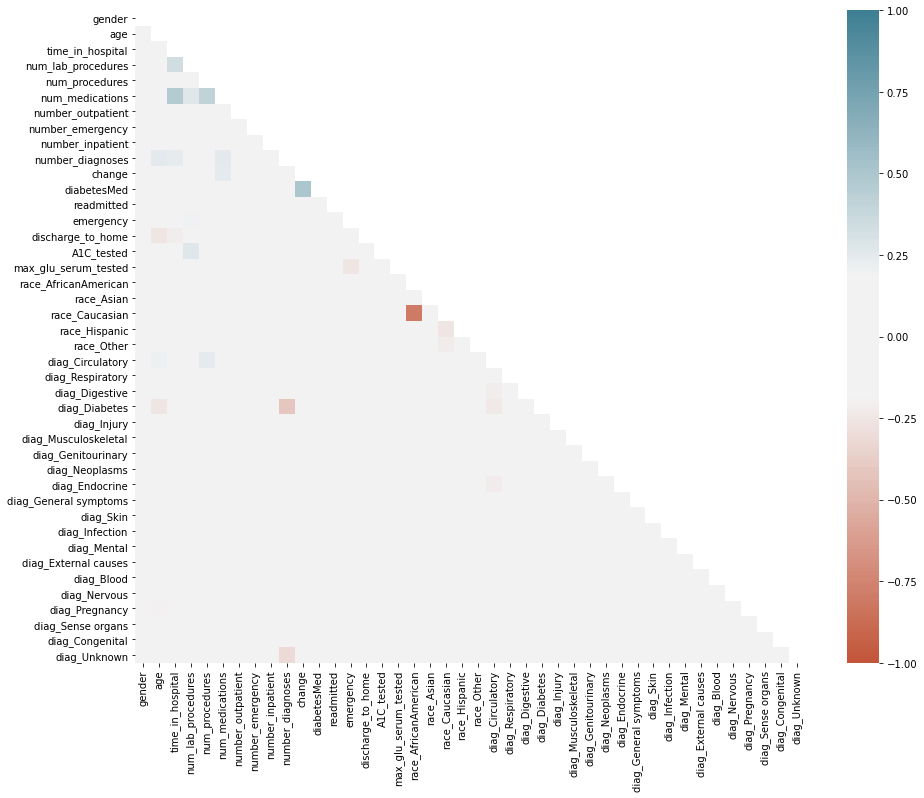

In [31]:
# plt.figure(figsize=(15,12))
# sns.heatmap(df4.corr(method='pearson'))


mask = np.triu(np.ones_like(df4.corr(method='pearson')))
plt.figure(figsize=(15,12))
sns.heatmap(df4.corr(method='pearson'),
            #annot=True,
            fmt=".2f",
            vmin=-1,
            vmax=1,
            mask=mask,
            cmap=sns.diverging_palette(20, 220, n=200, sep=50)
           )
plt.show()

#### Removing correlated variables

In [32]:
#df4.drop(["race_Caucasian"], axis=1, inplace=True)

In [131]:
# def delete_rows_csr(mat, indices):
#     """
#     Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
#     """
#     indices = list(indices)
#     mask = np.ones(mat.shape[0], dtype=bool)
#     mask[indices] = False
#     return mat[mask]

# bow = load_npz("../data/processed/bow.npz")

# X = hstack((
#     df4.drop("readmitted", axis=1).values,
#     delete_rows_csr(bow.copy(), idx_dup)  # deletes duplicate patients while keeping only the first entry
# ))

y = df4['readmitted'].values

X = df4.drop("readmitted", axis=1).values

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33634)

# from imblearn.over_sampling import RandomOverSampler
# oversampler = RandomOverSampler()
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE, RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [167]:
X_train.shape

(97888, 40)

In [173]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score

for k in range(2,X.shape[1]+1):
    pipeline = Pipeline([    
        ("scaler", StandardScaler()),
        ("varthres", VarianceThreshold()),
        ("select", SelectKBest(f_classif, k=k)),
        ("clf", xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=33634))
    ])
    pipeline.fit(X_train, y_train) 
    roc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
    #roc = roc_auc_score(y_test, pipeline.decision_function(X_test))
    recall = recall_score(y_test, pipeline.predict(X_test))
    precision = precision_score(y_test, pipeline.predict(X_test))
    f1 = f1_score(y_test, pipeline.predict(X_test))
    print("k = {}, ROC: {:.3f}, recall: {:.3f}, precision: {:.3f}, F1: {:.3f}".format(k, roc, recall, precision, f1))

k = 2, ROC: 0.604, recall: 0.518, precision: 0.134, F1: 0.213
k = 3, ROC: 0.610, recall: 0.568, precision: 0.124, F1: 0.204
k = 4, ROC: 0.605, recall: 0.502, precision: 0.125, F1: 0.200
k = 5, ROC: 0.598, recall: 0.497, precision: 0.124, F1: 0.199
k = 6, ROC: 0.605, recall: 0.474, precision: 0.128, F1: 0.201
k = 7, ROC: 0.589, recall: 0.425, precision: 0.122, F1: 0.190
k = 8, ROC: 0.602, recall: 0.442, precision: 0.129, F1: 0.200
k = 9, ROC: 0.602, recall: 0.443, precision: 0.128, F1: 0.198
k = 10, ROC: 0.602, recall: 0.442, precision: 0.128, F1: 0.199
k = 11, ROC: 0.605, recall: 0.450, precision: 0.127, F1: 0.198
k = 12, ROC: 0.600, recall: 0.443, precision: 0.126, F1: 0.196
k = 13, ROC: 0.609, recall: 0.471, precision: 0.133, F1: 0.207
k = 14, ROC: 0.607, recall: 0.443, precision: 0.129, F1: 0.200
k = 15, ROC: 0.610, recall: 0.443, precision: 0.129, F1: 0.200
k = 16, ROC: 0.598, recall: 0.446, precision: 0.131, F1: 0.203
k = 17, ROC: 0.604, recall: 0.430, precision: 0.129, F1: 0.199


In [130]:
roc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
#roc = roc_auc_score(y_test, pipeline.decision_function(X_test))
print(roc)

0.6317079662412618


## Modeling

In [35]:
# candidates = [
#     ("Random Forest",
#      RandomForestClassifier(n_estimators=300, random_state=33634),
#      {
#         "max_depth": [2,4,6,8,10,12,15],
#         "class_weight": [None, "balanced"],
#         "criterion": ["gini", "entropy"],
#         "max_features": ["sqrt", 0.5, "log2"]    
#     }),
    
#     ("XGboost",
#      xgb.XGBClassifier(random_state=33634, use_label_encoder=False),
#      {
#         'min_child_weight': [1, 5, 10],
#         "eval_metric": ["error", "logloss"],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#          "n_estimators": [5, 10, 20, 40, 80, 160, 320],
#         "class_weight": [None, "balanced"],
#     }),
    
#     ("Logistic Regression",
#     LogisticRegression(random_state=33634, max_iter=1000),
#     {
#         'penalty':['l1', 'l2', 'elasticnet'],        # l1 is lasso, l2 is ridge
#         'solver':['liblinear', 'newton-cg', 'lbfgs'],
#         'class_weight': [None, "balanced"],
#         'C': loguniform(1e-5, 100)
#     }),
    
#    ("Complement NB",
#    ComplementNB(),
#     {
#         "alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#     }
#    ) 
    
# ]

# cv_results = {} 
# cv = StratifiedKFold(n_splits=10, random_state=33634)
# for name, clf, params in candidates:
#     grid = RandomizedSearchCV(clf, 
#                                params,
#                                cv=cv, 
#                                scoring="roc_auc",
#                                verbose=10, 
#                                n_jobs=5, 
#                                random_state=33634)
#     grid.fit(X_train, y_train)
#     print("Classifier:", name)
#     print('Best Score:', grid.best_score_)
#     print('Best Hyperparameters:', grid.best_params_)
#     print("-"*30)
#     cv_results[name] = grid.cv_results_



Fitting 30 folds for each of 10 candidates, totalling 300 fits
Classifier: Random Forest
Best Score: 0.6359149159108815
Best Hyperparameters: {'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}
------------------------------
Fitting 30 folds for each of 10 candidates, totalling 300 fits
Classifier: XGboost
Best Score: 0.6327605155852284
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 20, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1, 'eval_metric': 'error', 'colsample_bytree': 1.0, 'class_weight': None}
------------------------------
Fitting 30 folds for each of 10 candidates, totalling 300 fits


/usr/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.62510928        nan 0.59133605        nan
        nan 0.62645234 0.62491957 0.626599  ]
  warnings.warn(


Classifier: Logistic Regression
Best Score: 0.6265989993166173
Best Hyperparameters: {'C': 0.0020133040799146, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
------------------------------
Fitting 30 folds for each of 6 candidates, totalling 180 fits


/usr/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classifier: Complement NB
Best Score: 0.6048153120381753
Best Hyperparameters: {'alpha': 0.001}
------------------------------


Although several candidate models performed great with the training set, it doesn't mean they will score just as great with the validation set. A clue of this fact lies in the standard deviation of each score. A high standard deviation value probably means the model didn't generalize well enough. Therefore the best parameters should be those with a low standard deviation and high average result.

In [36]:
pd.DataFrame(cv_results["Random Forest"]).sort_values("mean_test_score", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,param_criterion,param_class_weight,params,split0_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
7,18.831863,0.618084,0.301816,0.025394,sqrt,10,entropy,None,"{'max_features': 'sqrt', 'max_depth': 10, 'cri...",0.633772,...,0.670895,0.626331,0.616900,0.626739,0.624588,0.643828,0.630297,0.635915,0.012636,1
9,20.991430,0.439739,0.335212,0.028115,sqrt,12,gini,None,"{'max_features': 'sqrt', 'max_depth': 12, 'cri...",0.633502,...,0.674065,0.623154,0.613375,0.625289,0.622780,0.641921,0.627680,0.635122,0.013865,2
8,18.633447,0.667572,0.305511,0.028709,sqrt,10,gini,None,"{'max_features': 'sqrt', 'max_depth': 10, 'cri...",0.631372,...,0.671017,0.624022,0.614368,0.627014,0.618364,0.638805,0.626190,0.634096,0.013010,3
1,29.709574,0.753222,0.189361,0.003507,0.5,6,entropy,balanced,"{'max_features': 0.5, 'max_depth': 6, 'criteri...",0.627981,...,0.662447,0.621486,0.615048,0.624203,0.619981,0.647216,0.620478,0.631920,0.012587,4
5,22.151099,0.407882,0.416920,0.009885,log2,15,gini,None,"{'max_features': 'log2', 'max_depth': 15, 'cri...",0.629907,...,0.667644,0.618715,0.610207,0.620687,0.619088,0.634226,0.629343,0.631679,0.013334,5


In [49]:
# Parameters estimated via GridSearchCV 
# 0.649 params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.24}
# 0.649 params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}
# 0.644 params = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 0.24}
# 0.646 params = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt'}

params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.24}
clf = RandomForestClassifier(n_estimators=1000, random_state=33634, **params)

clf.fit(X_train, y_train)
coefs = clf.feature_importances_

print("ROC: {:.3f}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))

ROC: 0.646


In [38]:
pd.DataFrame(cv_results["XGboost"]).sort_values(["mean_test_score"], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_gamma,param_eval_metric,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
7,4.270032,0.104783,0.026047,0.007001,1.0,20,5,4,1,error,...,0.666178,0.624480,0.611713,0.623739,0.616887,0.638616,0.619842,0.632761,0.012952,1
4,3.080436,0.083604,0.025205,0.007262,1.0,20,10,3,0.5,error,...,0.659601,0.623560,0.619405,0.625829,0.619634,0.638620,0.619664,0.631578,0.012693,2
6,4.387310,0.103094,0.024289,0.004395,0.6,20,10,4,0.5,error,...,0.662243,0.612299,0.618241,0.629658,0.622558,0.646692,0.618810,0.630628,0.012554,3
9,11.562404,0.650287,0.026021,0.007085,0.6,80,10,3,2,logloss,...,0.653732,0.617537,0.606906,0.621542,0.621897,0.636278,0.622221,0.628935,0.012637,4
3,3.117017,0.104234,0.022343,0.003521,0.8,10,5,5,5,logloss,...,0.661083,0.619499,0.607885,0.620997,0.614186,0.633060,0.616419,0.628842,0.013299,5


In [39]:
params = {'subsample': 1.0, 'n_estimators': 40, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 0.5, 'eval_metric': 'logloss', 'colsample_bytree': 1.0, 'class_weight': None}
clf = xgb.XGBClassifier(random_state=33634, **params)
clf.fit(X_train, y_train)
coefs = clf.feature_importances_
print("ROC (test set): {:.3f}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))

/home/soldeace/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ROC (test set): 0.639


In [40]:
pd.DataFrame(cv_results["Logistic Regression"]).sort_values(["mean_test_score"], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
9,3.586023,0.277588,0.008330,0.000645,0.002013,balanced,l2,newton-cg,"{'C': 0.0020133040799146, 'class_weight': 'bal...",0.619225,...,0.658079,0.613917,0.611233,0.621102,0.604264,0.641461,0.620321,0.626599,0.012127,1
7,4.421620,0.223957,0.008814,0.000805,0.01269,balanced,l2,newton-cg,"{'C': 0.012689671807095088, 'class_weight': 'b...",0.618063,...,0.658701,0.615507,0.608791,0.620094,0.603430,0.641928,0.620721,0.626452,0.012231,2
2,3.182567,0.232480,0.008880,0.000714,0.000746,balanced,l2,newton-cg,"{'C': 0.0007457761370162312, 'class_weight': '...",0.618074,...,0.655563,0.609808,0.612192,0.620459,0.603993,0.639434,0.619971,0.625109,0.012081,3
8,6.863896,0.480078,0.008712,0.000723,0.057119,None,l2,newton-cg,"{'C': 0.05711857300463607, 'class_weight': Non...",0.616312,...,0.656439,0.613924,0.607772,0.617710,0.600512,0.638190,0.619997,0.624920,0.012502,4
4,0.339293,0.025112,0.009500,0.001691,0.000551,balanced,l1,liblinear,"{'C': 0.0005505665402873719, 'class_weight': '...",0.591699,...,0.580567,0.581521,0.580696,0.593405,0.597288,0.592197,0.613207,0.591336,0.010813,5


In [41]:
params = {'C': 0.012936, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
clf =  LogisticRegression(random_state=33634, max_iter=1000)
clf.fit(X_train, y_train)
coefs = clf.coef_[0]
print("ROC (test set): {:.3f}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))

ROC (test set): 0.632


In [42]:
pd.DataFrame(cv_results["Complement NB"]).sort_values("std_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060663,0.006099,0.013483,0.005781,1,{'alpha': 1},0.592334,0.606648,0.611845,0.607157,...,0.617289,0.602173,0.586706,0.604831,0.597597,0.618131,0.608912,0.604674,0.010881,6
2,0.058701,0.002756,0.011672,0.000625,0.01,{'alpha': 0.01},0.592382,0.607160,0.611525,0.607233,...,0.617440,0.601940,0.586916,0.604891,0.597543,0.618415,0.609393,0.604814,0.010887,4
5,0.059364,0.006820,0.011548,0.001623,0.00001,{'alpha': 1e-05},0.592381,0.607168,0.611518,0.607229,...,0.617444,0.601941,0.586916,0.604889,0.597541,0.618418,0.609399,0.604815,0.010888,2
4,0.060256,0.003576,0.011742,0.000646,0.0001,{'alpha': 0.0001},0.592381,0.607168,0.611518,0.607229,...,0.617444,0.601941,0.586916,0.604888,0.597541,0.618417,0.609399,0.604815,0.010888,3
3,0.061984,0.006300,0.012013,0.002411,0.001,{'alpha': 0.001},0.592380,0.607166,0.611518,0.607229,...,0.617445,0.601940,0.586917,0.604890,0.597543,0.618418,0.609399,0.604815,0.010888,1


In [43]:
clf = ComplementNB()
clf.fit(X_train, y_train)
coefs = clf.coef_[0]
print("ROC (test set): {:.3f}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))


ROC (test set): 0.607


/usr/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


## Evaluation

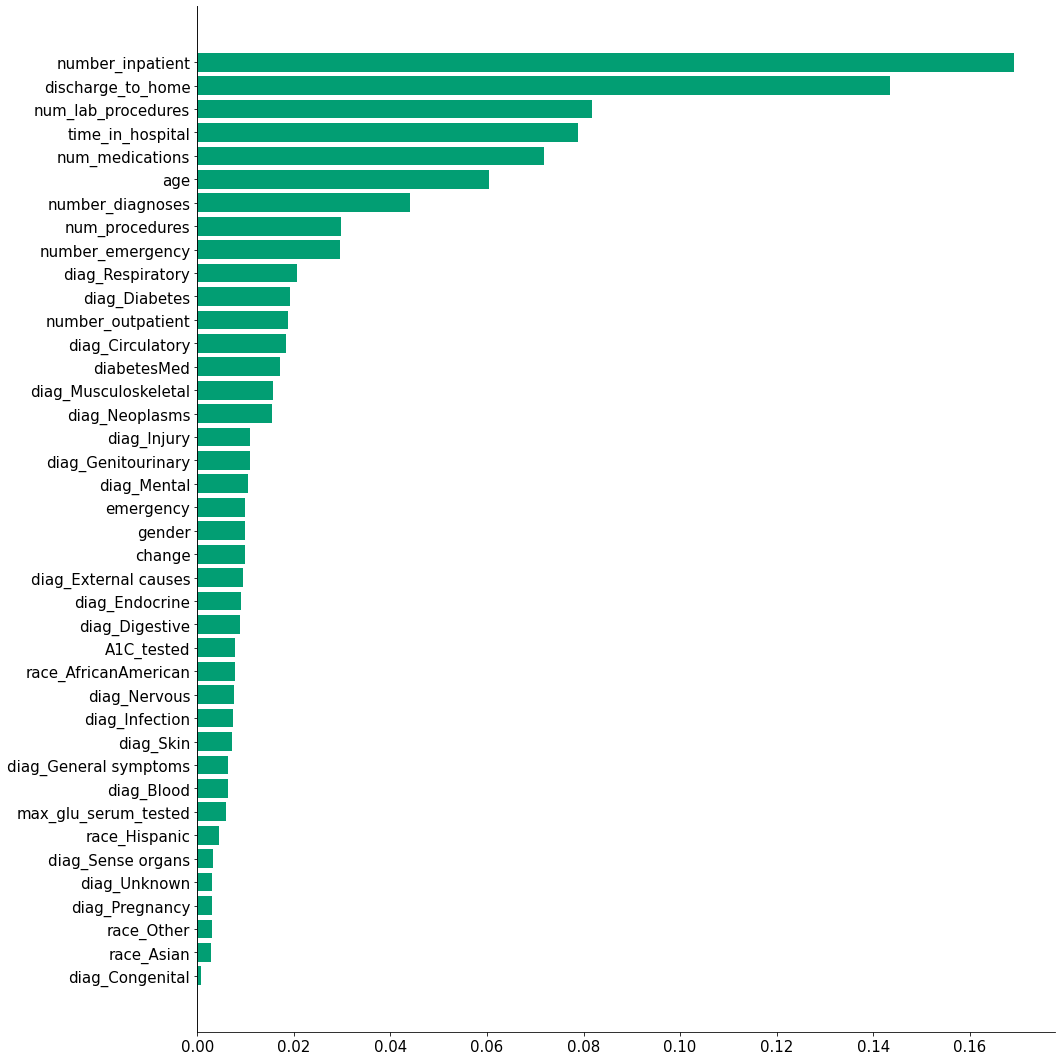

In [50]:
palette = sns.color_palette("colorblind").as_hex()
colors = [palette[3] if x < 0 else palette[2] for x in coefs[coefs.argsort()]]
pos = range(len(coefs))
plt.figure(figsize=(15, 15))
plt.barh(pos, coefs[coefs.argsort()], color=colors)
plt.yticks(pos, X.columns[coefs.argsort()])
plt.axvline(x=0, color='.2')
sns.despine()
plt.tight_layout()
plt.savefig("../reports/coef.png")
plt.show()

In [45]:
df4.columns.values[df4.columns.str.contains("diag_")]

array(['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive',
       'diag_Diabetes', 'diag_Injury', 'diag_Musculoskeletal',
       'diag_Genitourinary', 'diag_Neoplasms', 'diag_Endocrine',
       'diag_General symptoms', 'diag_Skin', 'diag_Infection',
       'diag_Mental', 'diag_External causes', 'diag_Blood',
       'diag_Nervous', 'diag_Pregnancy', 'diag_Sense organs',
       'diag_Congenital', 'diag_Unknown'], dtype=object)

[Text(0, 0, 'Circulatory'),
 Text(0, 1, 'Respiratory'),
 Text(0, 2, 'Digestive'),
 Text(0, 3, 'Diabetes'),
 Text(0, 4, 'Injury'),
 Text(0, 5, 'Musculoskeletal'),
 Text(0, 6, 'Genitourinary'),
 Text(0, 7, 'Neoplasms'),
 Text(0, 8, 'Endocrine'),
 Text(0, 9, 'General symptoms'),
 Text(0, 10, 'Skin'),
 Text(0, 11, 'Infection'),
 Text(0, 12, 'Mental'),
 Text(0, 13, 'External causes'),
 Text(0, 14, 'Blood'),
 Text(0, 15, 'Nervous'),
 Text(0, 16, 'Pregnancy'),
 Text(0, 17, 'Sense organs'),
 Text(0, 18, 'Congenital'),
 Text(0, 19, 'Unknown')]

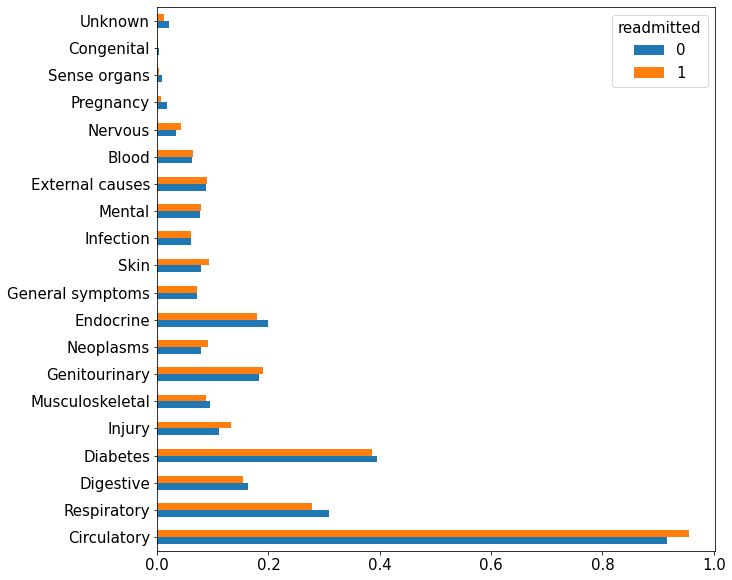

In [46]:
diag_labels = df4.columns[df4.columns.str.contains("diag_")]
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(10,10))
df4.groupby("readmitted")[diag_labels].mean().T.plot.barh(ax=ax)
ax.set_yticklabels(diag_labels.str.replace("diag_", ""))
#ax.patches[20].set_color("steelblue")


- Diabetes is underreported among patients that are going to be readmitted due to diabetes complication.

In [ ]:
df4.groupby("readmitted")[["diabetesMed", "change"]].mean().T.plot.bar()


## References

- https://raw.githubusercontent.com/drobbins/ICD9/master/output/output.txt